Pau Ruiz 217962
<br> Paula Sarrà 216886
<br> Jordi Valsells 218862

# Project IR-WA

#### Load Python packages
Let's first import all the packages that you will need during this assignment.

In [1]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import re
import json
import random
import pandas as pd
import collections
import matplotlib.pyplot as plt

## PART 1: Text Processing

#### Load data into memory
The dataset is stored in the TSV file, and it contains 500 Wikipedia articles (one article per line). For each article we have the document id, document title and document body separated by "|" character.

In [3]:
#Path of the document
docs_path = 'inputs/dataset_tweets_WHO.txt'

# String of path to file: tweets_data_path
tweets_data_path = 'inputs/dataset_tweets_WHO.txt'

# Open connection to file
tweets_file = open(tweets_data_path, "r")

# Read in tweets and store in list: tweets_data
for line in tweets_file:
    tweets_data_raw = json.loads(line)

# Close connection to file
tweets_file.close()

#Change str keys to int
tweets_data = {int(key):value for key, value in tweets_data_raw.items()}

# Print first tweet of the dict
#print(tweets_data[0])

#Total number of tweets
print('\nTotal number of tweets: {}'.format(len(tweets_data)))


Total number of tweets: 2399


In [4]:
#print a tweet
tweets_data[0]

{'created_at': 'Wed Oct 13 09:15:58 +0000 2021',
 'id': 1448215930178310144,
 'id_str': '1448215930178310144',
 'full_text': "It's International Day for Disaster Risk Reduction\n\n#OpenWHO has launched a multi-tiered core curriculum to help equip you with the competencies needed to work within public health emergency response.\n\nStart learning today &amp; be #Ready4Response:\n👉 https://t.co/hBFFOF0xKL https://t.co/fgZY22RWuS",
 'truncated': False,
 'display_text_range': [0, 274],
 'entities': {'hashtags': [{'text': 'OpenWHO', 'indices': [52, 60]},
   {'text': 'Ready4Response', 'indices': [232, 247]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/hBFFOF0xKL',
    'expanded_url': 'https://bit.ly/3wCa0Dr',
    'display_url': 'bit.ly/3wCa0Dr',
    'indices': [251, 274]}],
  'media': [{'id': 1448215398814560259,
    'id_str': '1448215398814560259',
    'indices': [275, 298],
    'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/1448215398814560259/pu/img/0CO

In [5]:
def build_terms(line):
    """
    Preprocess the tweet (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    hashtags - a list of hashtags that the text contained
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    line = line.lower() ## Transform in lowercase
    line = re.sub(r'http\S+', '', line) ## remove links
    line = re.sub(r'[^A-Za-z0-9#\n ]+', '', line) ## remove special characters (not # yet)
    line = line.split() ## Tokenize the text to get a list of terms
    
    hashtags=[]
    
    for word in range(len(line)):
        if line[word][0]=='#':
            line[word]=line[word].replace('#', '') ## now remove # too
            hashtags.append(line[word]) ## and add to the list of hashtags
            
    line = [word for word in line if word not in stop_words]  ##eliminate the stopwords
    line = [stemmer.stem(word) for word in line] ## perform stemming
    
    return line, hashtags

In [6]:
length=len(tweets_data)
hashtags={}

#we apply our function build terms to the tweets dataset and also save the hashtags in a list
for key in range(length):
    tweets_data[key]['full_text'], hashtags[tweets_data[key]['id']] = build_terms(tweets_data[key]['full_text'])

## PART 2: Indexing and Evaluation

## Indexing

### Inverted index

In [7]:
def create_index(tweets_data):
    """
    Implement the inverted index
    
    Argument:
    lines -- collection of tweets 
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of tweets where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    title_index = {}
    for tweet in tweets_data:  # Remember, lines contain all documents
        tweet_id = int(tweets_data[tweet]['id'])
        terms =  tweets_data[tweet]['full_text']#page_title + page_text
        title = " ".join(tweets_data[tweet]['full_text'])
        title_index[tweet_id]=title
        
        ## ===============================================================        
        ## create the index for the current page and store it in current_page_index (current_page_index)
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                
        ## START CODE
                current_page_index[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[tweet_id, array('I',[position])] #'I' indicates unsigned int (int in Python)
            
        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)
        
        ## END CODE                    
                    
    return index, title_index

In [8]:
start_time = time.time()
index, title_index = create_index(tweets_data)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 0.09 seconds


In [9]:
def search(query, index):
    """
    The output is the list of tweets that contain any of the query terms. 
    So, we will get the list of tweets for each query term, and take the union of them.
    """
    query, hashtags = build_terms(query)
    docs = set()
    for term in query:
    ## START DODE
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]            
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    return docs

In [10]:
print("Insert your query:\n")

query = input()
docs = search(query, index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(top, len(docs)))
for d_id in docs[:top]:
    print("\n TWEET= {} - tweet_id: {}".format(title_index[d_id],d_id))    

Insert your query:

covid19 flight

Sample of 10 results out of 738 for the searched query:


 TWEET= covid19 shown health emerg disast affect entir commun especi weak health system vulner popul like migrant indigen peopl live fragil humanitarian condit - tweet_id: 1448208458604584960

 TWEET= rt opsom si est completament vacunado pued contraer covid19 importa si est vacunado si todava est esperando - tweet_id: 1448163383493136385

 TWEET= rt drtedro covid19 major impact peopl mentalhealth thank doctorja whophilippin dedic work - tweet_id: 1448031156348362754

 TWEET= rt drtedro must appreci role privat sector play covid19 respons develop vaccin short - tweet_id: 1448049654923468803

 TWEET= rt drtedro donat arent enough deliv vaccinequ end covid19 pandem need stronger leadership ramp - tweet_id: 1448031115428696064

 TWEET= live drtedro end covid19 pandem road inclus recoveri vaccinequ - tweet_id: 1447972516161490944

 TWEET= take climateactioncal countri must set ambiti commit sustai

### 5 Queries

In [11]:
def find_keywords():
    """
    Find the most repeated words in the dataset.
    """
    wordcount = {}
    for key in range(length):
        words = tweets_data[key]['full_text']
        for word in words:
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1
    n_print = int(input("How many most common words to print: "))
    print("\nOK. The {} most common words are as follows\n".format(n_print))
    word_counter = collections.Counter(wordcount)
    for word, count in word_counter.most_common(n_print):
        print(word, ": ", count)
find_keywords()

How many most common words to print: 10

OK. The 10 most common words are as follows

amp :  1030
drtedro :  979
health :  774
covid19 :  759
rt :  549
vaccin :  545
countri :  395
peopl :  353
support :  271
global :  254


### TF-IDF

In [12]:
def create_index_tfidf(tweets_data, num_tweets):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of tweets
    num_documents -- total number of tweets
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in tweets (tweets in the same order as in the main index)
    df = defaultdict(int)  #tweet frequencies of terms in the corpus
    title_index = defaultdict(str)
    idf = defaultdict(float)

    for tweet in tweets_data:
        
        tweet_id = int(tweets_data[tweet]['id'])
        terms =  tweets_data[tweet]['full_text']#page_title + page_text
        title = " ".join(tweets_data[tweet]['full_text'])
        title_index[tweet_id]=title
        ## ===============================================================        
        ## create the index for the **current page** and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[tweet_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] +=1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_tweets/df[term])), 4)

    return index, tf, df, idf, title_index


In [13]:
start_time = time.time()
num_tweets = len(tweets_data)
index, tf, df, idf, title_index = create_index_tfidf(tweets_data, num_tweets)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 53.15 seconds


In [14]:
def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each tweet 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores_df = [x[0] for x in doc_scores]
    docs_id_df = [x[1] for x in doc_scores]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_doc_scores = [x[0] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    
    return result_docs, doc_scores_df, docs_id_df

In [15]:
def search_tf_idf(query, index):
    """
    output is the list of tweets that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query, hashtags = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, doc_scores_df, docs_id_df = rank_documents(query, docs, index, idf, tf, title_index)
    
    return ranked_docs, doc_scores_df, docs_id_df

## Creating dataframe to perform evaluation

In [17]:
our_queries=['covid19 vaccine', 'pandemic', 'health access', 'countries support', 'people care']

queries_df = pd.DataFrame()
for i in range(5):
    print("Insert your query:\n")
    query = our_queries[i]
    ranked_docs, doc_scores_df, docs_id_df = search_tf_idf(query, index)
    
    hashtag_found = [0]*len(docs_id_df)
    
    for word in query.split():
        for doc in range(len(docs_id_df)):
            for h in hashtags[docs_id_df[doc]]:
                #print(h)
                if h == word:
                    hashtag_found[doc] = 1 #as it is binary
    if i == 0:
        queries_df = pd.DataFrame()
        queries_df['doc_id'] = docs_id_df
        queries_df['q_id'] = i
        queries_df['predicted_relevance'] = doc_scores_df
        queries_df['y_true'] = hashtag_found
    else:
        #print("here")
        query_df = pd.DataFrame()
        query_df['doc_id'] = docs_id_df
        query_df['q_id'] = i
        query_df['predicted_relevance'] = doc_scores_df
        query_df['y_true'] = hashtag_found
        queries_df = pd.concat([queries_df, query_df], ignore_index=True)
    
    top = 10

    print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
    for d_id in ranked_docs[:top]:
        print("tweet_id= {} - tweet: {}".format(d_id, title_index[d_id]))

Insert your query:


Top 10 results out of 887 for the searched query:

tweet_id= 1418489081026154497 - tweet: mrna covid19 vaccin safe vaccin read
tweet_id= 1432284372690866186 - tweet: covid19 vaccin could save life get vaccin soon turn
tweet_id= 1426206173225787392 - tweet: rt whowpro encourag love one get vaccin covid19 help regist get vaccin site vaccin
tweet_id= 1418545630494924805 - tweet: covid19 vaccin halal read
tweet_id= 1416433609091653633 - tweet: covid19 vaccin covid19 vaccin 10 countri rest vaccinequ end pandem togeth worldemojiday
tweet_id= 1408416636084707335 - tweet: get vaccin even covid19
tweet_id= 1430183353638998018 - tweet: facilit effect vaccin deliveri person disabl health provid provid access covid19 vaccin info amp vaccin process ensur access vaccin site vaccinequ
tweet_id= 1439194751538974723 - tweet: rt drtedro glad thank covid19 vaccin walk vaccin process omanconvent storag
tweet_id= 1437865493118005248 - tweet: who global covid19 vaccin target 70 popul co

In [18]:
queries_df

,doc_id,q_id,predicted_relevance,y_true
0,1448208458604584960,0,0.201941,1
1,1448163383493136385,0,0.177700,0
2,1448049654923468803,0,0.849441,1
3,1448031156348362754,0,0.285646,1
4,1448031115428696064,0,0.264472,1
...,...,...,...,...
2766,1409489891797446656,4,0.834446,0
2767,1408450795570335747,4,1.152974,0
2768,1408450214139240452,4,1.274653,0
2769,1408449858365710339,4,0.956125,0


## Evaluation

In [19]:
search_results = queries_df

### Precision@K (P@K)

In [20]:
def precision_at_k(y_true, y_score, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    order = np.argsort(y_score)
    order = order[::-1]
    y_true = np.take(y_true, order[:k])
    relevant = sum(y_true == 1)
    precision = float(relevant)/k
    return precision

##### Precision@10 for query with q_id=0

In [21]:
# Check for query 0
k=10

current_query = 0
current_query_res = search_results[search_results["q_id"] == 0] 
temp = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)

print("==> Precision@{}: {}\n".format(k,
                                precision_at_k(current_query_res["y_true"], current_query_res["predicted_relevance"], k)))

print("\nCheck on the dataset sorted by score:\n")
current_query_res.sort_values("predicted_relevance", ascending=False).head(k)

==> Precision@10: 0.9


Check on the dataset sorted by score:



,doc_id,q_id,predicted_relevance,y_true
520,1418489081026154497,0,1.815488,1
253,1432284372690866186,0,1.548168,1
334,1426206173225787392,0,1.536664,1
515,1418545630494924805,0,1.531077,1
730,1408416636084707335,0,1.531077,1
556,1416433609091653633,0,1.531077,0
268,1430183353638998018,0,1.525690,1
158,1439194751538974723,0,1.424210,1
167,1437865493118005248,0,1.424210,1
214,1435321728197177347,0,1.372348,1


### Precision for all queries

In [22]:
for i in range(0,5):

    current_query_res = search_results[search_results["q_id"] == i] 
    temp = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
    k=10

    print("==> Precision@{}: {}\n".format(k, precision_at_k(current_query_res["y_true"], current_query_res["predicted_relevance"], k)))




==> Precision@10: 0.9

==> Precision@10: 0.0

==> Precision@10: 0.1

==> Precision@10: 0.0

==> Precision@10: 0.0



### Average Precision@k - AP@K


In [23]:
def avg_precision_at_k(y_true, y_score, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    
    gtp = sum(y_true==1)
    order = np.argsort(y_score)
    order = order[::-1]
    y_true = np.take(y_true, order[:k])            

    ## if all docs are not relevant
    if gtp==0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i+1)
    
    avg_precision_at_k = prec_at_i / gtp
    
    return avg_precision_at_k

##### Average precision @ 10 for query with q_id=0

In [24]:
k = 10
#compute avg precision
current_query_res = search_results[search_results["q_id"] == 0] 

temp = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
avg_precision = avg_precision_at_k(np.array(temp["y_true"]), np.array(temp["predicted_relevance"]), k)
print("Average precision at %d is %4f"%(k, avg_precision))

# Check with average_precision_score of sklearn
from sklearn.metrics import average_precision_score
temp = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
avg_precision_sklearn = average_precision_score(np.array(temp["y_true"]), np.array(temp["predicted_relevance"][:k]))
print("Average precision at %d is %4f"%(k, avg_precision_sklearn))



Average precision at 10 is 0.906041
Average precision at 10 is 0.911287


We see we obtain almost the same result, so we can say that we have implemented the average precision correctly

### Mean Average Precision (MAP)



In [25]:
def map_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in search_res["q_id"].unique(): #loop over all query id
        curr_data = search_res[search_res["q_id"] == q]  # select data for current query
        temp = curr_data.sort_values("predicted_relevance", ascending=False).head(k)
        avp.append(avg_precision_at_k(np.array(temp["y_true"]), np.array(temp["predicted_relevance"]), k)) #append average precision for current query
    
    map_k = np.sum(avp) / len(avp)
    
    return map_k, avp # return mean average precision

##### MAP@10 for all queries of the dataset

In [26]:
map_k, avp = map_at_k(search_results, 10)
map_k

0.20620811287477953

### Average precision for all queries to check result of MAP

In [27]:
for q in range(0,5): #loop over all query id
        curr_data = search_results[search_results["q_id"] == q]  # select data for current query
        temp = curr_data.sort_values("predicted_relevance", ascending=False).head(10)
        print('Average precision of query', q, avg_precision_at_k(np.array(temp["y_true"]), np.array(temp["predicted_relevance"]), 10)) 
    

Average precision of query 0 0.9060405643738976
Average precision of query 1 0
Average precision of query 2 0.125
Average precision of query 3 0
Average precision of query 4 0


### Mean Reciprocal Rank (MRR)



In [28]:
def rr_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for qurrent query
    '''

    order = np.argsort(y_score)
    order = order[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(y_true) == 0: # if there are not relevant doument return 0
        return 0
    
    mrr = 1 / (np.argmax(y_true == 1) + 1)
    
    return mrr # hint: to get the position of the first relevant document use "np.argmax"

##### MRR@K for k=3, 5 and 10.

In [29]:
mrr = {}
for k in [3,5,10]:
    RRs = []
    for q in search_results['q_id'].unique(): # loop over all query ids
        labels = np.array(search_results[search_results['q_id']==q]['y_true']) # get labels for current query
        scores = np.array(search_results[search_results['q_id']==q]['predicted_relevance']) # get predicted score for current query
        scores_sorted = -np.sort(-scores) #sorting the scores with a numpy array
        RRs.append(rr_at_k(labels, scores_sorted, k)) # append RR for current query
    mrr[k] = np.round(float(sum(RRs) / len(RRs)),4) # Mean RR at current k
mrr

{3: 0.2, 5: 0.2, 10: 0.2}

### Multiple levels of relevance metrics

### NDCG - Normalized Discounted Cumulative Gain

 

In [30]:
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)
    order = order[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = (2 ** y_true) - 1 # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):    
    dcg_max = dcg_at_k(y_true, y_true,  k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score,  k) / dcg_max, 4)  # return ndcg@k

#### the 𝑁𝐷𝐶𝐺@10 for query with q_id=0

In [31]:
k = 10


for q_id in range(0,5):

    labels = np.array(search_results[search_results['q_id'] == q_id]["y_true"])
    scores = np.array(search_results[search_results['q_id'] == q_id]["predicted_relevance"])
    scores_sorted = -np.sort(-scores) #sorting the scores with a numpy array
    ndcg_k = np.round(ndcg_at_k(labels, scores_sorted, k),4)
    print("ndcg@{} for query with q_id={}: {}".format(k,q_id,ndcg_k))

ndcg@10 for query with q_id=0: 0.8611
ndcg@10 for query with q_id=1: 0
ndcg@10 for query with q_id=2: 0.0
ndcg@10 for query with q_id=3: 0
ndcg@10 for query with q_id=4: 0


#### Average 𝑁𝐷𝐶𝐺@10 (considering all queries/rankings).

In [32]:
ndcgs = []
k=10
for q in search_results['q_id'].unique(): # loop over all query ids
    labels = np.array(search_results[search_results['q_id'] == q]["y_true"]) ## get labels for current query
    scores = np.array(search_results[search_results['q_id'] == q]["predicted_relevance"]) # get predicted score for current query
    scores_sorted = -np.sort(-scores) #sorting the scores with a numpy array
    ndcgs.append(np.round(ndcg_at_k(labels, scores_sorted, k), 4)) # append NDCG for current query

avg_ndcg = np.round(float(sum(ndcgs) / len(ndcgs)),4) # Compute average NDCG
print("Average ndcg@{}: {}".format(k,avg_ndcg))


Average ndcg@10: 0.1722


### Vector representation

In [33]:
all_words = []
for key in range(length):
    all_words.append(tweets_data[key]["full_text"])

In [34]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

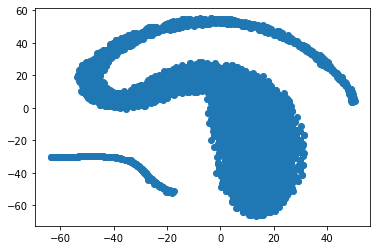

In [35]:
model= Word2Vec(all_words, workers=4, vector_size=100, min_count=1, window=5)
X = model.wv[model.wv.index_to_key]
model_2 = TSNE(n_components=2, random_state=0)
X_2 = model_2.fit_transform(X)
x=X_2[:,0]
y=X_2[:,1]
plt.scatter(x,y)